<a href="https://colab.research.google.com/github/Siddharthgolecha/HighQ/blob/main/QOSF_Mentorship_Task_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Basic Setup

##Installing required packages

For this task, I am using Qiskit along with PyTorch to complete it.

Installing packages:

* Qiskit v 0.18.3
* Pytorch v 1.9.0+cu102


In [1]:
!pip install qiskit
!pip install torch

     |████████████████████████████████| 6.1 MB 4.6 MB/s 
     |████████████████████████████████| 17.9 MB 123 kB/s 
     |████████████████████████████████| 235 kB 44.8 MB/s 
     |████████████████████████████████| 207 kB 71.6 MB/s 
     |████████████████████████████████| 2.1 MB 25.9 MB/s 
     |████████████████████████████████| 200 kB 57.9 MB/s 
     |████████████████████████████████| 1.4 MB 46.2 MB/s 
     |████████████████████████████████| 634 kB 62.6 MB/s 
     |████████████████████████████████| 52 kB 1.1 MB/s 
     |████████████████████████████████| 38.2 MB 21 kB/s 
     |████████████████████████████████| 49 kB 5.6 MB/s 
     |████████████████████████████████| 943 kB 36.8 MB/s 
     |████████████████████████████████| 3.5 MB 20.1 MB/s 
     |████████████████████████████████| 6.3 MB 21.0 MB/s 
  Created wheel for qiskit: filename=qiskit-0.30.1-py3-none-any.whl size=11697 sha256=21aa425acb8bcabec1f896b240c31a0e26032e5857035bfc4afedb547782591a
  Stored in directory: /root/.cache/pip/whe

##Importing the required libraries

The libraries to be imported are:

* Qiskit
* Pytorch
* Numpy
* Matplotlib

In [42]:
import qiskit
import numpy as np
import torch
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister, Aer
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt

In [10]:
print(qiskit.__version__)
print(qiskit.__qiskit_version__)

0.18.3
{'qiskit-terra': '0.18.3', 'qiskit-aer': '0.9.0', 'qiskit-ignis': '0.6.0', 'qiskit-ibmq-provider': '0.16.0', 'qiskit-aqua': '0.9.5', 'qiskit': None, 'qiskit-nature': None, 'qiskit-finance': None, 'qiskit-optimization': None, 'qiskit-machine-learning': None}


In [11]:
print(torch.__version__)

1.9.0+cu102


#Generating Random States

##Creating TrainingData and Label classes to faciliate training

* TrainingData - Creates a dataset of random values of required bit length and size
* Labels - Wrapper class for the predefined output labels

In [14]:
class TrainingData:
  """
  Creates a Training Dataset of random quantum states.

  Args:
      bit_len (int): The number of bits required to represent a state.
      size (int): The size of dataset required for training. Minimum can be 1
                  and maximum (n^2)
      backend (AerBackend): The backend required to run the quantum simulation
                            for random state generation. If not set, the 
                            QASM Simulator will be chosen as default.
      shots (int): The number of shots provided to the backend. Default value 
                   is 1024.
  
  Raises: 
      TypeError: Raises the error, if the type determined is not valid.
      ValueError: Raises the error, if the size is either less than 1 or
                  greater than n^2.

  """

  def __init__(self, bit_len, size, backend=Aer.get_backend('qasm_simulator'),
               shots=1024):
    
    if not isinstance(bit_len, int):
      raise TypeError("The length of bits must be an integer instead of {}.".
                      format(type(bit_len).__name__))
    if not isinstance(size, int):
      raise TypeError("The size of dataset must be an integer instead of {}.".
                      format(type(size).__name__))
    
    if size < 1:
      raise ValueError("The minimum size of dataset must be 1.")
    if size > bit_len**2:
      raise ValueError("The maximum size of dataset can be generated from {} \
      qubits is {}".format(bit_len, bit_len**2))

    self.bit_len = bit_len
    self.backend = backend
    self.shots = shots
    self.size = size
    counts = self.generate_samples(self.bit_len, self.backend, self.shots)

    while len(counts) < self.size: 
      #Generates samples again if they less the required size
      counts = self.generate_samples(self.bit_len, self.backend, self.shots)

    #Sort the dictionary based on the count of states
    self.counts = dict(sorted(counts.items(), 
                         key=lambda item: item[1]))
    self._samples = list(self.counts.keys())[:self.size]
    self.params = None

  def generate_samples(self, qubits, backend=Aer.get_backend('qasm_simulator'),
               shots=1024):
    """
    Returns the samples and its counts generated by a random circuit.

    Args:
        qubits (int): The number of quantum bits and classical bits to generate
                      samples.
        backend (AerBackend): The backend required to run the quantum simulation
                              for random state generation. If not set, the 
                              QASM Simulator will be chosen as default.
        shots (int): The number of shots provided to the backend. Default value 
                     is 1024.
    """
    circuit = QuantumCircuit(qubits,qubits)
    for i in range(qubits):
      args = np.random.rand(3)*2*np.pi
      circuit.u(args[0], args[1], args[2], i)
      circuit.measure(i,i)
    result = backend.run(circuit, shots=shots).result()
    counts = result.get_counts()

    return counts

  def to_params(self):
    """
    Returns the dataset converted from states into angles(radians) for quantum
    circuit.

    Returns:
        Ndarray: A 2D array of shape (self.size, self.bit_len) with paramaters
                 to be passed to QNNCircuit for training.
    """
    self.params = np.zeros((self.size,self.bit_len))
    for index in range(self.size):
      sample = self.samples[index]
      for i in range(self.bit_len):
        state = sample[i]
        if state=="1":
          #RY(π/2)|0> = X|0> = |1>
          self.params[index][self.bit_len-i-1] = np.pi/2 
    return self.params

  @property
  def samples(self):
    """
    Returns the samples generated by the random circuit

    Returns:
        List: A list of length 'size' containing different samples generated by
              the quantum circuits 
    """
    return self._samples

  @samples.setter
  def samples(self, samples):
    self._samples = samples

  def __str__(self):
    return str(self.samples)

In [60]:
class Labels:
  """
  Creates a wrapper for labels for training the model

  Args:
      data (list(str)): A list of strings containing different states to be
                        generated by the model.

  Raises:
      TypeError: Raises an error, if any of the element is either not string or
                 a binary string
  """

  def __init__(self, *data):

    if isinstance(data[0], list):
      data = data[0]
    for label in data:
      if not isinstance(label, str):
        raise TypeError("Expected a string of strings but recieved a {}".
                        format(type(label).__name__))
      try:
        check = int(label,2)
      except TypeError:
        raise TypeError("The label {} is not a binary string".format(label))
    
    self._data = list(data)
    self.size = len(self.data)
    self.bit_len = len(self.data[0])

  @property
  def data(self):
    """
    Returns the labels

    Returns:
        List: List of binary labels for validation
    """
    return self._data

  @data.setter
  def data(self, data):
    self._data = data

  def __str__(self):
    return str(self._data)

In [61]:
random_states = TrainingData(4, size=4)
labels = Labels('0011', '0101', '1010', '1100')
print(random_states)

['1000', '0011', '0001', '0000']


**Aim**: To map these newly random states to the predefined label states

For example - 

* 0010 -> 0011
* 0011 -> 0101
* 0111 -> 1010
* 1000 -> 1100

**Proposed Solution**: Use Hybrid QGANs with Quantum Generators and Classical Discriminator to generate a required states for the random states.

#Design Quantum Circuit for QNN

The quantum circuit consists of alternating group of RY and RZ gates followed by full entanglement of CNOT gates. Taking the 32 theta and 4 label values, the quantum circuit can look like -


![Quantum Circuit](https://drive.google.com/uc?export=view&id=16_h1xaog79R0hBN4tBUWkiswNSYlo5yd)


In [29]:
class QNNCircuit:
  """ 
  Creates a Quantum Neural Network Circuit for Quantum Generator

  Args:
      kernel_size (int): The number of qubits in the Quantum Neural Network
                         Circuit.
      backend (AerBackend): The backend required to run the quantum simulation
                            for random state generation. If not set, the 
                            QASM Simulator will be chosen as default.
      shots (int): The number of shots provided to the backend. Default value 
                   is 1024.
  
  Raises: 
      TypeError: Raises the error, if the type determined is not valid.
  """
    
  def __init__(self, kernel_size,
               backend=Aer.get_backend('qasm_simulator'),
               shots = 1024):
      
    if not isinstance(kernel_size, int):
      raise TypeError("The number of qubits must be an integer instead of {}.".
                      format(type(kernel_size).__name__))

    # --- Circuit definition ---
    self.kernel_size = kernel_size
    self.training_qubits = QuantumRegister(kernel_size, name="training")
    self.measuring_register = ClassicalRegister(kernel_size, "meas")
    self.circuit = QuantumCircuit(self.training_qubits, 
                                  self.measuring_register)
    # ---------------------------
    self.backend = backend
    self.shots = shots
   
  def create_circuit(self, thetas, label):
    """
    Add the gates and assign parameters to Quantum Circuit.

    Args:
        thetas (list(float), ndarray(float)): Training parameters to assign to
                                              the quantum circuit.
        label (list(float), ndarray(float)): Parameters to initialize the
                                             state to the circuit.
      
    Raises:
        TypeError: Raises an error if the arguments are neither list nor
                   ndarray.
        ValueError: Raises an erorr if label size is not equal to kernel_size
    """

    if not isinstance(thetas, (list, np.ndarray)):
      raise TypeError("Expected a list of floating or integer values but \
      recieved a {} for thetas".format(type(thetas).__name__))
    if not isinstance(label, (list, np.ndarray)):
      raise TypeError("Expected a list of floating or integer values but \
      recieved a {} for label".format(type(label).__name__))
    if len(label) != self.kernel_size:
      raise ValueError("Expected a size of {} for label but recieved {}".
                       format(self.kernel_size, len(label)))

    if isinstance(thetas, np.ndarray):
      thetas = thetas.tolist()
    if isinstance(label, np.ndarray):
      label = label.tolist()

    #Initialising the Quantum state on the Quantum Circuit
    #RY(π/2)|0> = |1>
    #RY(0)|0> = |0> 
    for i in range(len(label)):
      self.circuit.ry(label[i], self.training_qubits[i])

    for i in range(len(thetas)):
      #Fully entangled CNOT gates after each RY and RZ gates pair
      if (i%(2*self.kernel_size))==0 and i!=0:
        for j in range(self.kernel_size):
          for k in range(j+1,self.kernel_size):
            self.circuit.cnot(self.training_qubits[j],
                              self.training_qubits[k])

      #Alternating RY and RZ gates      
      if (i//self.kernel_size)%2 == 0:
        self.circuit.ry(thetas[i], 
                        self.training_qubits[i%self.kernel_size])
      else:
        self.circuit.rz(thetas[i], 
                        self.training_qubits[i%self.kernel_size])
        
  def expval(self):
    """
    Calculates the expectation value of the created circuit. 

    Expectation Value = Sum(state(i)*probability(i))

    Returns:
        Float: Expectation value of the quantum circuit.
    """
    expval = 0
    result = self.get_states()
    for key,val in result.items():
      expval += key*val
    return expval

  def get_states(self):
    """
    Measures the quantum circuit and outputs the probability of each state

    Returns:
        Dict(string: float): Probaility of different states measured by the
                             quantum circuit
    """

    self.circuit.measure(self.training_qubits, self.measuring_register)
    job = self.backend.run(self.circuit, shots=self.shots)
    counts = job.result().get_counts()
    output = {key: val/self.shots for key, val in counts.items()}
    return output

#Defining Hybrid Quantum GAN

The Hybrid Quantum GAN consists of Quantum Generator and Classical Discriminator

* **Quantum Generator** - It takes the random states and uses QNNCircuit to generate the probability of all the possible states.
* **Classical Discriminator** - It takes the probabilties generated by the generator to check if it is producing real or fake outputs.

In [46]:
def get_accuracy(pred_list, actual):
  """
  Determines the average accuracy of the generated data.

  Args:
      pred_list (list(list(float))): Probabilty of different states of different
                                     random input states
      actual (list(str)): Correct labels which is used to determine the accuracy

  Returns:
      float: Returns the accuracy of the output generated by the generator
  """
  total = 0
  for i in range(len(pred_list)):
    total += pred_list[i][int(actual[i],2)]
  return total/len(pred_list)

In [47]:
def hotshot(counts, bit_len):
  """
  Converts the different states and its probability into a list of all state
  relative probabilities wrt highest probable state.

  Args:
      counts (dict(str:float)): Dictionary with different states as the keys and
                                probailities as its values
      bit_len (int): The length of bits provided   

  Returns:
      list(float): List of probabilities of state converted into the index of 
                   the list                 
  """
  new_count = []
  max_val = max(list(counts.values()))
  for i in range(bit_len*bit_len):
    key = "{0:b}".format(i).zfill(bit_len)
    if key in counts:
      new_count.append(counts[key]/max_val)
    else:
      new_count.append(0.0)
  return new_count

In [74]:
class QNNModel(nn.Module):
  """ 
  Quantum Nueral Network model to generate different states

  Args:
      kernel_size (int): The number of qubits in the Quantum Neural Network
                         Circuit.
      backend (AerBackend): The backend required to run the quantum simulation
                            for random state generation. If not set, the 
                            QASM Simulator will be chosen as default.
      shots (int): The number of shots provided to the backend. Default value 
                   is 1024.
      n_params (int): Number of parameters to be trained. If not set, 8 will be
                      chosen as deafult.

  Raises:
      ValueError: Raises the error, if the size is less than 1
  """
    
  def __init__(self,kernel_size,
               backend = Aer.get_backend('qasm_simulator'),
               shots = 1024, n_params = 8):
      
    super(QNNModel, self).__init__()

    if n_params < 1:
      raise ValueError("The minimum number of parameters must be 1.")
        
    self.backend = backend
    self.kernel_size = kernel_size
    self.shots = shots
    self.n_params = n_params
    self.param = nn.Parameter(torch.rand(self.n_params,
                                         requires_grad=True)*np.pi)
        
  def forward(self, data):
    """
    Performs forward propogation

    Args:
        data (TrainingData): Random training data to initialize the state

    Returns:
        tensor: Tensor of different probabilities of different input states  
    """
    size = len(data.samples)
    self.circuits = [QNNCircuit(self.kernel_size) for i in range(size)]
    param = self.param.data.numpy()
    data_params = data.to_params()

    for i in range(size):
      self.circuits[i].create_circuit(param, data_params[i])
        
    output = [hotshot(self.circuits[i].get_states(), 
              self.kernel_size) for i in range(size)]
    return torch.tensor(output)

In [50]:
class Discriminator(nn.Module):
  """
  Creates a discriminator for the GANs. Contains a single Linear layer
  followed by the sigmoid activation function.

  Args:
      n (int): The number of neurons in the hidden layer.

  Returns:
      float: The probailility of given output state 
  """
  def __init__(self, n):
        super(Discriminator, self).__init__()
        self.dense = nn.Linear(int(n), 1);
        self.activation = nn.Sigmoid()

  def forward(self, x):
        return self.activation(self.dense(x))

In [72]:
def GAN_training(generator, discriminator, g_optimizer, d_optimizer,
                 loss_fn, g_loss_list = [], d_loss_list = [], 
                 g_accuracy_list = [], d_accuracy_list = [], epochs = 15000):
  """
  Trains the GAN with given generator and discriminator

  Args:
      generator (torch.nn.Module): Generator for GAN
      discriminator (torch.nn.Module): Discriminator for GAN
      g_optimizer (torch.optim): Generator's Optimizer
      d_optimizer (torch.optim): Discriminator's Optimizer
      loss_fn (torch.nn.Loss): Loss function for Discriminator
      g_loss_list (list): List to store Generator's Loss
      d_loss_list (list): List to store Discriminator's Loss
      g_accuracy_list (list): List to store Generator's Accuracy
      d_accuracy_list (list): List to store Discriminator's Accuracy
      epochs (int): Number of iterations for GAN. Deafult value is 15000

  """

  true_labels = torch.full((labels.size,), 1, dtype=torch.float)
  true_data = torch.tensor([hotshot({state:1},labels.bit_len) 
                            for state in labels.data])

  fake_labels = torch.zeros(labels.size)

  generator.train()
  discriminator.train()
  for epoch in range(1,epochs+1):

    # Forward pass
    g_optimizer.zero_grad()

    # Generate the data on the random states
    g_out = generator(random_states)
    g_accuracy = get_accuracy(g_out, labels.data)
    
    # Calculate the Discriminator's loss on output of random states and true
    # labels
    g_d_out = discriminator(g_out).view(-1)
    g_loss = loss_fn(g_d_out, true_labels)

    # Train the discriminator on the true data and true labels
    d_optimizer.zero_grad()
    true_d_out = discriminator(true_data).view(-1)
    true_d_loss = loss_fn(true_d_out, true_labels)

    # Train the discriminator on the output of random states and fake labels
    g_d_f_out = discriminator(g_out.detach()).view(-1)
    g_d_loss = loss_fn(g_d_f_out, fake_labels)
    d_loss = true_d_loss + g_d_loss
    d_loss.backward()
    d_optimizer.step()

    # Backpropogation of Generator
    g_loss.backward()
    g_optimizer.step()

    g_loss_list.append(g_loss.item())
    d_loss_list.append(d_loss.item())
    g_accuracy_list.append(g_accuracy)
    d_accuracy_list.append(true_d_out.mean(0).detach().numpy())

    if epoch%1000==0:
      print('Epoch {:03d}\tGenerator Loss: {:.4f}\tGenerator Accuracy: {:.4f}\t'.
              format(epoch, g_loss.item(), g_accuracy), end='')
      print('Discriminator Loss: {:.4f}\tDiscriminator Accuracy: {:.4f}'.
            format(d_loss.item(), d_accuracy_list[-1]))

#Train the Hybrid Quantum GAN

In [83]:
qgenerator = QNNModel(kernel_size=4, n_params=32)
qdiscriminator = Discriminator(qgenerator.kernel_size**2)

qg_optimizer = optim.Adam(qgenerator.parameters())
qd_optimizer = optim.Adam(qdiscriminator.parameters(), lr=0.001)

qloss_fn = nn.BCELoss()
epochs = 15000

qg_loss_list = []
qd_loss_list = []

qg_accuracy_list = []
qd_accuracy_list = []

GAN_training(qgenerator, qdiscriminator, qg_optimizer, qd_optimizer,
             qloss_fn, qg_loss_list, qd_loss_list, qg_accuracy_list,
             qd_accuracy_list, epochs = 15000)

Epoch 1000	Generator Loss: 1.9247	Generator Accuracy: 0.4301	Discriminator Loss: 0.4518	Discriminator Accuracy: 0.7560
Epoch 2000	Generator Loss: 2.8220	Generator Accuracy: 0.4441	Discriminator Loss: 0.2039	Discriminator Accuracy: 0.8774
Epoch 3000	Generator Loss: 3.2595	Generator Accuracy: 0.4309	Discriminator Loss: 0.1222	Discriminator Accuracy: 0.9318
Epoch 4000	Generator Loss: 3.8882	Generator Accuracy: 0.4463	Discriminator Loss: 0.0738	Discriminator Accuracy: 0.9597
Epoch 5000	Generator Loss: 5.1541	Generator Accuracy: 0.4210	Discriminator Loss: 0.0379	Discriminator Accuracy: 0.9755
Epoch 6000	Generator Loss: 5.0866	Generator Accuracy: 0.4039	Discriminator Loss: 0.0249	Discriminator Accuracy: 0.9846
Epoch 7000	Generator Loss: 6.6369	Generator Accuracy: 0.4491	Discriminator Loss: 0.0167	Discriminator Accuracy: 0.9903
Epoch 8000	Generator Loss: 6.4657	Generator Accuracy: 0.4427	Discriminator Loss: 0.0092	Discriminator Accuracy: 0.9937
Epoch 9000	Generator Loss: 7.1595	Generator Accu

#Results and Conclusions

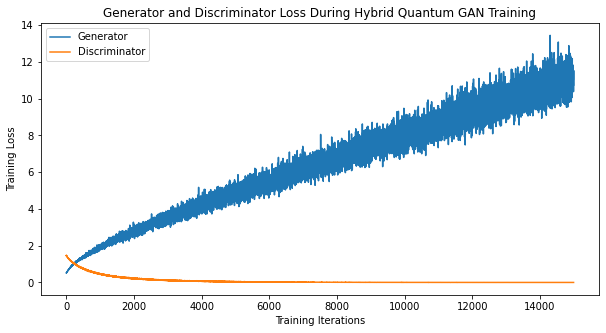

In [84]:
plt.figure(figsize=(10,5))
plt.title("Generator and Discriminator Loss During Hybrid Quantum \
GAN Training")
plt.plot(qg_loss_list, label='Generator')
plt.plot(qd_loss_list, label='Discriminator')
plt.xlabel('Training Iterations')
plt.ylabel('Training Loss')
plt.legend()
plt.show()

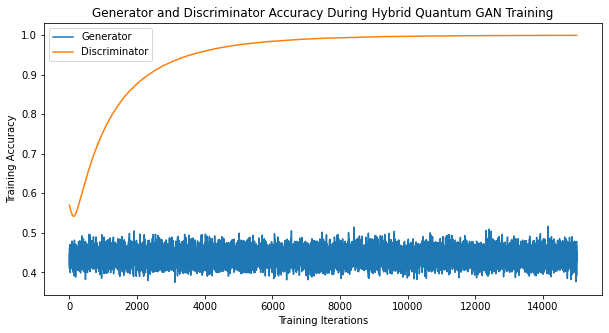

In [85]:
plt.figure(figsize=(10,5))
plt.title("Generator and Discriminator Accuracy During Hybrid Quantum \
GAN Training")
plt.plot(qg_accuracy_list, label='Generator')
plt.plot(qd_accuracy_list, label='Discriminator')
plt.xlabel('Training Iterations')
plt.ylabel('Training Accuracy')
plt.legend()
plt.show()

##Conclusions

By analyzing the Generator's and Discriminator's Loss Graph of Hybrid Quantum GAN, we can see that the loss of the Generator is continously increasing while Discriminator's loss is decreasing. This indicates that the Hybrid QGAN model is reaching failure mode. The discriminator can easily identify that the random quantum states cannot produce the predefined output states. It can also be said that the generator is not able to produce the states with probable states.

This can also be verified by analysing the accuracy graph. It shows that the disciminator is becoming good at finding that the given outputs don't correspond to the actual labels. For the ideal GAN model,

* The accuracy of generator should reach 100%.
* The Discriminator's loss should be around 0.5 indicating it is facing hard time deciding if the generator is producing the correct results.

###Possible Solutions

* **Increasing the number of iterations**: Increasing the number of iterations in GANs usually help the generator to produce good data. However, in this case it seem unlikely it will help because with increasing iterations, the loss does not seem to rise to 0.5 or become constant.
* **Decreasing the learning rate of Discriminator's optimizer**: This ensures that the discriminator learns slowly so that generator could get enough time to generate good data. However, during my trails, it also does not seem to work much.
* **Change the Quantum Circuit**: The reason why the generator is not producing the convincing results is that the circuit is not good enough. However, I tried different quantum circuit but none of them seemed to work much good.

#Testing the Quantum Generator

In [86]:
def GAN_test(generator, states, labels):
  """
  Tests the GAN generator.

  Args:

      generator (torch.nn.Module): GAN Generator
      states (TrainingData): Training Data to generate result
      labels (Labels): Output Labels
  """
  generator.eval()
  with torch.no_grad():
    output = generator(states)
    for i in range(len(labels.data)):
      output_dict = {"{0:b}".format(key).zfill(labels.bit_len):output[i][key] 
                for key in range(len(output[i]))}
          
      out_state = max(output_dict, key = lambda x: output_dict[x])
      print("Random State = {}\tActual Label = {}\t".
              format(states.samples[i], labels.data[i]), end=' ')
      print("Output Label = {}\tActual Label Accuracy = {:.2f}%".
            format(out_state, output_dict[labels.data[i]]*100))

In [87]:
GAN_test(qgenerator, random_states, labels)

Random State = 1000	Actual Label = 0011	 Output Label = 1001	Actual Label Accuracy = 25.33%
Random State = 0011	Actual Label = 0101	 Output Label = 0101	Actual Label Accuracy = 100.00%
Random State = 0001	Actual Label = 1010	 Output Label = 1011	Actual Label Accuracy = 34.64%
Random State = 0000	Actual Label = 1100	 Output Label = 1001	Actual Label Accuracy = 19.71%


In [90]:
new_states = TrainingData(4, size=4)
GAN_test(qgenerator, new_states, labels)

Random State = 1010	Actual Label = 0011	 Output Label = 1101	Actual Label Accuracy = 1.40%
Random State = 1000	Actual Label = 0101	 Output Label = 1001	Actual Label Accuracy = 4.93%
Random State = 1011	Actual Label = 1010	 Output Label = 1101	Actual Label Accuracy = 55.69%
Random State = 1001	Actual Label = 1100	 Output Label = 1011	Actual Label Accuracy = 2.94%
